In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

Model parameters:

SIR
Suceptible
Infected
Removed

g is infection/growth rate. Abstract representation, is not broken down further.

S starts at 1, reduced by I and R at any timestep

I grows by B\*I every timestep.

R increases by R\*r where the r is b from two weeks prior.

r is made up of the death rate d and the recovery rate.

recovery rate is assumed to be 1 if patient survives two weeks.

information available:
D total deaths, most reliable

R total recovered

assumed information:

death rate d=0.01 of recovered people

mean recovery time 14 days

recovery rate = 1/14 per day

b is constant over the inspected  time interval

In [33]:
def calc_growth_rate(death_csv_path, state, window_size=10, window_end=datetime.date.today()):
    '''
    This function calculates a growth rate per (susceptible * infected) population in the target state.
    It uses a simple SIR model to work backward from death counts since active infection counts are
    considered unreliable due to the lack of widespread testing. If the dead are not being tested for 
    COVID-19 then this will be an unreliable estimator as well.
    
    The expected dataset is the one provided by JHU on their github here:
    https://github.com/CSSEGISandData/COVID-19
    Specifically the US time series deaths CSV
    
    Args:
      death_csv_path (string): The path to the death count time series csv mentioned above.
      state (string): The name of the state to target. This must match what is in the data CSV.
      window_size (int): The size of the window in days to calculate and average growth rate over.
      window_end (string): The end day of the window. Should be given as 'YYYY-MM-DD'
      
    Returns:
      float: average growth rate of the virus over the window specified
      float: average number of people infected per day over the window specified.
    '''
    
    d = 0.01  # Death rate per infection
    r = 1/14.0  # Recovery rate days^-1, inverse of average infection time. Aka gamma
    
    death_df = pd.read_csv(death_csv_path)
    
    # Find what column the time series starts at
    cols = death_df.columns
    for num, col in enumerate(cols):
        try:
            month, day, year = tuple(col.split('/'))
            break
        except:
            continue
    
    # Convert the window end to a number of days from the start of the recording.
    start_time = datetime.date(int(year)+2000, int(month), int(day))
    window_end = (datetime.date.fromisoformat(window_end) - start_time).days
    
    # D is the vector of deaths in the state of interest over time
    D = death_df[death_df['Province_State'] == state].iloc[:, num:].values.sum(axis=0)
    
    # Start working backward
    dD = np.diff(D)  # Total dD
    I = dD/d/r  # Infected count
    dI = I[-lookback] - I[-1]  # dI/dt
    Iave = np.average(I[window_end-window_size:window_end]) # Average I over window of interest
    dD = D[window_end-window_size] - D[window_end]  # dD/dt over the window of interest
    
    # Need to calculate recovered over all periods to have an accurate count of the susceptible population
    # Deaths are a fraction of recovered population
    # All values must be averaged over the lookback window
    Rave = np.average(D[window_end-window_size:window_end]/d)
    S0 = death_df['Population'].sum()
    Save = S0 - Iave - Rave
    
    # Calculate infection growth rate g
    g = (dIave + dDave/d)/(Save*Iave)
    
    # Calculate a number of new infected per day, easier for a human to understand
    I_per_day = g*Save*Iave
    
    return g, I_per_day

In [34]:
path = './data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
calc_growth_rate(path, 'New York', window_size=10, window_end='2020-05-20')

(2.859379664147387e-10, 26810.0)

Everything below this was scratch work for what is in the function above.

In [2]:
death_df = pd.read_csv('./data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')

In [3]:
# Define analysis parameters
state = 'New York'
d = 0.01  # Death rate per infection
r = 1/14.0  # Recovery rate days^-1, inverse of average infection time. Aka gamma
lookback = 10  # Look back to find infection rate across this many days

In [4]:
cols = death_df.columns
for num, col in enumerate(cols):
    try:
        month, day, year = tuple(col.split('/'))
        break
    except:
        continue
        
D = death_df[death_df['Province_State'] == state].iloc[:, num:].values.sum(axis=0)

In [6]:
dD = np.diff(D)
I = dD/d/r
fit = np.polyfit(np.arange(len(D)-lookback, len(D)), D[-lookback:], deg=1)

In [11]:
# This cell estimates the infection rate over the lookback window
# Retry this using differentials over the window vs averages, averages may be wrong
dI = I[-lookback] - I[-1]  # dI/dt
Iave = np.average(I[-lookback:]) # Average I
dD = D[-lookback] - D[-1]  # dD/dt

# Need to calculate recovered over all periods to have an accurate count of the susceptible population
# Deaths are a fraction of recovered population
# All values must be averaged over the lookback window
Rave = np.average(D[-lookback:]/0.01)
S0 = death_df['Population'].sum()
Save = S0 - Iave - Rave

# Calculate infection growth rate g
g = (dIave + dDave/d)/(Save*Iave)

In [12]:
g

2.8595496005732873e-10

This is the growth rate per unit population susceptible and infected. if we multiply by the number of people suceptible and infected, should see a number that is more in line with how you think about it, as a number of newly infected people per day.

Growth rate represents and interaction rate * transmission rate.

In [13]:
g*Save*Iave

26809.999999999996

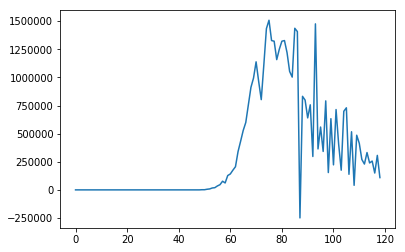

In [62]:
plt.plot(I)

In [59]:
# Work backward from D to get S
# eventually want to get to infection rate b
d = 0.01  # Assumed 1% death rate among infected
R = deaths.copy()

infection_time = datetime.timedelta(days=14)
newcols = []
colids = []
for col in R.columns:
    try:
        month, day, year = tuple(col.split('/'))
    except:
        newcols.append(col)
        colids.append(False)
        continue
    date = datetime.date(int(year), int(month), int(day))
    infect_date = date - infection_time
    newcols.append(infect_date.isoformat())
    colids.append(True)
    

R.loc[:,colids] = R.loc[:,colids].divide(d)

I = R.copy()
for col in I.columns:
    try:
        month, day, year = tuple(col.split('/'))
    except:
        newcols.append(col)
        colids.append(False)
        continue



In [60]:
S[S['Province_State'] == 'New York']

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,5/11/20,5/12/20,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20
1833,84036001,US,USA,840,36001.0,Albany,New York,US,42.600603,-73.977239,...,5900.0,6100.0,6200.0,6600.0,6700.0,6800.0,6800.0,6800.0,6900.0,6900.0
1834,84036003,US,USA,840,36003.0,Allegany,New York,US,42.257484,-78.027505,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1835,84036005,US,USA,840,36005.0,Bronx,New York,US,40.852093,-73.862828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1836,84036007,US,USA,840,36007.0,Broome,New York,US,42.159032,-75.813261,...,2300.0,2300.0,2800.0,2800.0,2800.0,2800.0,2800.0,2800.0,3000.0,3000.0
1837,84036009,US,USA,840,36009.0,Cattaraugus,New York,US,42.247782,-78.679231,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1838,84036011,US,USA,840,36011.0,Cayuga,New York,US,42.912617,-76.557316,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1839,84036013,US,USA,840,36013.0,Chautauqua,New York,US,42.227692,-79.366918,...,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
1840,84036015,US,USA,840,36015.0,Chemung,New York,US,42.138911,-76.763880,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1841,84036017,US,USA,840,36017.0,Chenango,New York,US,42.494300,-75.608876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1842,84036019,US,USA,840,36019.0,Clinton,New York,US,44.745309,-73.678754,...,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0
